# BindsNET Learning Techniques

## 1. Table of Contents
1. Table of Contents
2. Overview
3. Import Statements
4. Learning Rules
    1. PostPre
    2. Hebbian
    3. WeightDependentPostPre
    4. MSTDP
    5. MSTDPET
5. Custom Learning Rules


## 2. Overview

Detail documentation of usage of learning rules has been specified [here] (https://bindsnet-docs.readthedocs.io/guide/guide_part_ii.html). This document will go into more specific examples of configuring a spiking neural network in BindsNET.

The specified learning rule is passed into a `Connection` object via the `update_rule` argument. The connection encapsulates the learning rule object.

* `nu`: a 2-tuple pre- and post- synaptic learning rates (how quickly synapse weights change)
* `reduction`: specifies how parameter updates are aggregated across the batch dimension
* `weight_decay`: specifies the time constant of the rate of decay of synapse weights to zero

Parameter updates are averaged across the batch dimension by default, so there is no weight decay.


In [124]:
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre

# Create two populations of neurons, one to act as the "source"
# population, and the other, the "target population".
# Neurons involved in certain learning rules must record synaptic
# traces, a vector of short-term memories of the last emitted spikes.
source_layer = Input(n=100, traces=True)
target_layer = LIFNodes(n=1000, traces=True)

# Connect the two layers.
connection = Connection(
    source=source_layer, target=target_layer, update_rule=PostPre, nu=(1e-4, 1e-2)
)

## 3. Import Statements

In [125]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

from bindsnet.encoding import *
from bindsnet.network import Network
from bindsnet.network.monitors import Monitor
from bindsnet.network.monitors import NetworkMonitor

from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_input, plot_weights

from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre, Hebbian, WeightDependentPostPre, MSTDP, MSTDPET

from bindsnet.evaluation import all_activity, proportion_weighting, assign_labels
from bindsnet.utils import get_square_weights, get_square_assignments

## 4. Learning Rules

### 4a. PostPre

Simple STDP rule involving both pre- and post-synaptic spiking activity. By default, pre-synaptic update is negative and the post-synaptic update is positive.

| Parameters   | Type                                    | Description                                                                               | Default Value |
|--------------|-----------------------------------------|-------------------------------------------------------------------------------------------|---------------|
| connection   | AbstractConnection                      | An `AbstractConnection` object whose weights the `PostPre` learning rule will modify. |               |
| nu           | Optional\[Union\[float, Sequence\[float]]] | Single or pair of learning rates for pre- and post-synaptic events.                       | None          |
| reduction    | Optional\[callable]                      | Method for reducing parameter updates along the batch                                     | None          |
| weight_decay | float                                   | Constant multiple to decay weights by on each iteration.                                  | 0.0           |

Simulation Parameters

In [126]:
# set number of neurons
input_neurons = 9
lif_neurons = 2

# set number of classes
n_classes = 2

# simulation time
time = 100
dt = 1

per_class = int(lif_neurons / n_classes)

epochs = 10

Input Configuration

In [127]:
# input data
img0 = torch.flatten(torch.FloatTensor([[128,0,128],[0,128,0],[128,0,128]]))
img1 = torch.flatten(torch.FloatTensor([[0,128,0],[128,128,128],[0,128,0]]))
imgs = [img0,img1]

Network Configuration

In [128]:
# initialize network
network = Network()

# configure weights for the synapses between the input layer and LIF layer
w = torch.round(torch.abs(2 * torch.randn(input_neurons, lif_neurons)))
#print(w)

# initialize input and LIF layers
# spike traces must be recorded
input_layer = Input(n=input_neurons,traces=True)
lif_layer = LIFNodes(n=lif_neurons,traces=True)

# connection between the input layer and the LIF layer
connection = Connection(
    source=input_layer, target=lif_layer, w=w, update_rule=PostPre, nu=(1e-4, 1e-2)
)

# create a monitor
lif_layer_monitor = Monitor(
    obj=lif_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

# add layers to network
network.add_layer(
    layer=input_layer, name="Input Layer"
)
network.add_layer(
    layer=lif_layer, name="LIF Layer"
)

# add connection to network
network.add_connection(
    connection=connection, source="Input Layer", target="LIF Layer"
)

# add monitor to the network
network.add_monitor(monitor=lif_layer_monitor, name="LIF Layer")

Simulation Variables

In [129]:
# create input spike data, where each spike is distributed according to Bernoulli(0.1)
#input_data = torch.bernoulli(0.1 * torch.ones(time, input_layer.n)).byte()
encoder = BernoulliEncoder(time=time, dt=dt)
encoded_img0 = encoder(img0)
encoded_img1 = encoder(img1)
encoded_inputs = [{"Input Layer": encoded_img0},{"Input Layer": encoded_img1}]

# input_data = torch.bernoulli(0.1 * torch.ones(time, input_layer.n)).byte()
# encoded_image = input_data
# inputs = {"Input Layer": input_data}

# print(encoded_img0)

# Record spikes during the simulation.
spike_record = torch.zeros(1, int(time / dt), lif_neurons)


# Neuron assignments and spike proportions.
assignments = -torch.ones_like(torch.Tensor(lif_neurons))
proportions = torch.zeros_like(torch.Tensor(lif_neurons, n_classes))
rates = torch.zeros_like(torch.Tensor(lif_neurons, n_classes))

# Labels to determine neuron assignments and spike proportions and estimate accuracy
labels = torch.empty(1)

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)

Training

Below are descriptions of the functions required to train an SNN in BindsNET

---

`all_activity()`

Classify data with the label with highest average spiking activity over all neurons.

Returns a predictions tensor of shape `(n_samples,)` resulting from the "all activity" classification scheme (`torch.Tensor`)

| Parameter  | Type         | Description                                                                           | Default Value |
|-------------|--------------|---------------------------------------------------------------------------------------|---------|
| spikes      | `torch.Tensor` | Binary tensor of shape `(n_samples, time, n_neurons)` of a layer'sspiking activity. |         |
| assignments | `torch.Tensor` | A vector of shape `(n_neurons,)` of neuron label assignments.                       |         |
| n_labels    | `int`          | The number of target labels in the data.                                              |         |

----

`proportion_weighting()`

Classify data with the label with highest average spiking activity over all neurons, weighted by class-wise proportion.

Returns a predictions tensor of shape `(n_samples,)` resulting from the "proportion weighting" classification scheme (`torch.Tensor`)

| Parameter   | Type         | Description                                                                                              | Default Value |
|-------------|--------------|----------------------------------------------------------------------------------------------------------|---------------|
| spikes      | `torch.Tensor` | Binary tensor of shape `(n_samples, time, n_neurons)` of a single layer's spiking activity.            |               |
| assignments | `torch.Tensor` | A vector of shape `(n_neurons,)` of neuron label assignments.                                          |               |
| proportions | `torch.Tensor` | A matrix of shape `(n_neurons, n_labels)` giving the per-class proportions of neuron spiking activity. |               |
| n_labels    | `int`          | The number of target labels in the data.                                                                 |               |

----

`assign_labels()`

Assign labels to the neurons based on highest average spiking activity.

Returns a Tuple of class assignments, per-class spike proportions, and per-class firing rates (`Tuple[torch.Tensor, torch.Tensor, torch.Tensor]`)

| Parameter | Type                     | Descriptions                                                                                  | Default Value |   |   |
|------------|--------------------------|-----------------------------------------------------------------------------------------------|---------------|---|---|
| spikes     | `torch.Tensor`             | Binary tensor of shape `(n_samples, time, n_neurons)` of a single layer's spiking activity. | Required               |   |   |
| labels     | `torch.Tensor`             | Vector of shape `(n_samples,)` with data labels corresponding to spiking activity.          | Required               |   |   |
| n_labels   | `int`                      | The number of target labels in the data.                                                      | Required               |   |   |
| rates      | `Optional[torch.Tensor]` | If passed, these represent spike rates from a previous `assign_labels()` call.              | None          |   |   |
| alpha      | `float`                    | Rate of decay of label assignments.                                                           | 1             |   |   |


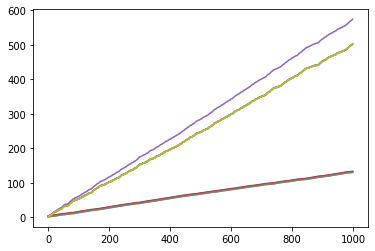

In [130]:
weight_history = None
first_pass = True
num_correct = 0.0
epochs = 1000

# simulate network on input data
for i in range(epochs):
    img_class = random.randint(0,n_classes-1)
    labels[0] = img_class
    # print(encoded_inputs[img_idx]["Input Layer"])

    # Run the network on the input.
    choice = np.random.choice(int(lif_neurons / n_classes), size=1, replace=False)
    # clamp: Mapping of layer names to boolean masks if neurons should be clamped to spiking. The ``Tensor``s have shape ``[n_neurons]`` or ``[time, n_neurons]``.
    # clamp on the output layer (Ae), forces the node corresponding to the label's class to spike
    clamp = {"LIF Layer": per_class * img_class + torch.Tensor(choice).long()}

    # inputs = {"X": image.view(time, 1, 1, 28, 28)}
    inputs = encoded_inputs[img_class]

    network.run(inputs=inputs, time=time, clamp=clamp)

    spike_record[0] = spikes["LIF Layer"].get("s").view(time, lif_neurons)

    all_activity_pred = all_activity(spike_record, assignments, n_classes)

    proportion_pred = proportion_weighting(spike_record, assignments, proportions, n_classes)

    assignments, proportions, rates = assign_labels( spike_record, labels, n_classes, rates )

    if(labels.numpy()[0] == all_activity_pred.numpy()[0]):
        num_correct += 1
    #print("[Previous Prediction]: "+str(all_activity_pred))
    #print("[Previous Actual]: "+str(labels.long()))
    #print("[Correct Prediction]: "+str(labels.long() == all_activity_pred))
    #print("[Weights]:"+str(network.connections[("Input Layer", "LIF Layer")].w))
    #print()
    weights = network.connections[("Input Layer", "LIF Layer")].w[:,0].numpy().reshape((1,input_neurons))
    if first_pass == True:
        weight_history = weights.copy()
        first_pass = False
    else:
        weight_history = np.concatenate((weight_history,weights),axis=0)

    #print("Accuracy: "+str(num_correct / epochs))

for idx in range(weight_history.shape[1]):
    plt.plot(weight_history[:,idx])
plt.show()

Plot Results

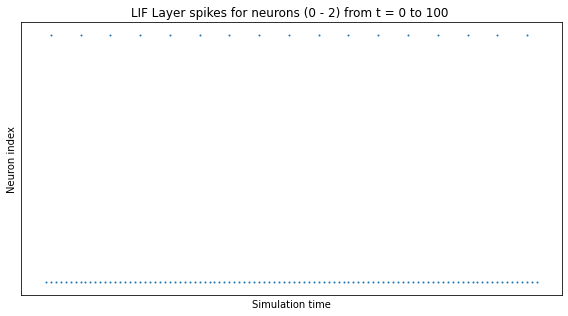

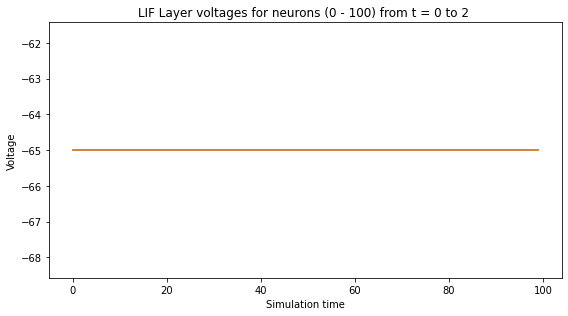

In [131]:
# retrieve and plot simulation spike, voltage data from monitors
spikes = {"LIF Layer": lif_layer_monitor.get("s")}
voltages = {"LIF Layer": lif_layer_monitor.get("v")}

# plot spikes and voltages of the LIF layer
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")

plt.show()

## 5. Custom Learning Rules

Custom learning rules can be implemented by subclassing `bindsnet.learning.LearningRule` and providing implementations for the types of `AbstractConnection` objects intended to be used. 

For example, the `Connection` and `LocalConnection` objects rely on the implementation of a private method, `_connection_update`, whereas the `Conv2dConnection` object uses the `_conv2d_connection_update` version.